In [23]:
! pip install kagglehub[pandas-datasets] av pymediainfo tqdm imageio[ffmpeg]

In [2]:
import kagglehub
from tqdm import tqdm

tqdm.pandas()


#Warning: This downloads the entire dataset (~5GB). If you already have the files downloaded, find some other way to download them
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")

path

c:\Users\skipz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'C:\\Users\\skipz\\.cache\\kagglehub\\datasets\\risangbaskoro\\wlasl-processed\\versions\\5'

# Importing the Data
Load in `WLASL_v0.3.json`, which contains `gloss`, i.e. the name of the item, and `instances`, describing each video instance.

We unpivot and flatten the structure of the dataset.

The missing video files are filtered out.

In [3]:
import pandas as pd
import json


with open(path + '/WLASL_v0.3.json') as f: 
    data = json.load(f)

with open(path + '/missing.txt') as f: 
    missing = set(line.strip() for line in f.readlines())

df = pd.DataFrame.from_records(data)
df = df.explode('instances').reset_index()

# Flatten the dataset
df = pd.concat([df['gloss'], pd.json_normalize(df['instances'])], axis=1)

# Filter out the videos in missing.txt
df = df[~df['video_id'].isin(missing)]

df.head()

,gloss,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id
0,book,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241
10,book,"[462, 44, 949, 720]",25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,07069
17,book,"[234, 17, 524, 414]",25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,07068
22,book,"[131, 26, 526, 480]",25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,07070
24,book,"[162, 54, 528, 400]",25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,07099


# Data analysis & selection
After removing the missing videos, there are a good number of words only 2 or 3 videos to train on. We will filter these out.

Additionally, only the video_id will be used in our final dataset, the rest of the information is not relevant to training.

           fps  frame_end   frame_start   instance_id     signer_id  \
count  11980.0    11980.0  11980.000000  11980.000000  11980.000000   
mean      25.0       -1.0      1.000250      6.353088     27.990150   
std        0.0        0.0      0.020429      4.515867     28.920946   
min       25.0       -1.0      1.000000      0.000000      0.000000   
25%       25.0       -1.0      1.000000      3.000000     11.000000   
50%       25.0       -1.0      1.000000      6.000000     13.000000   
75%       25.0       -1.0      1.000000      9.000000     38.000000   
max       25.0       -1.0      3.000000     39.000000    120.000000   

       variation_id  
count  11980.000000  
mean       0.054841  
std        0.232398  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        2.000000  


,video_id,label,bbox,frame_start
0,69241,book,"[385, 37, 885, 720]",1
1,07069,book,"[462, 44, 949, 720]",1
2,07068,book,"[234, 17, 524, 414]",1
3,07070,book,"[131, 26, 526, 480]",1
4,07099,book,"[162, 54, 528, 400]",1


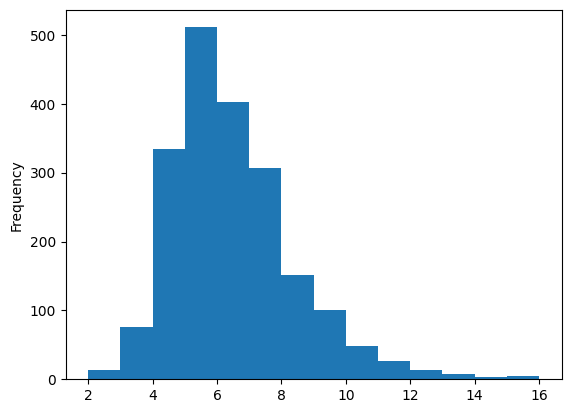

In [4]:
# Verify distribution of instances is very skewed
counts = df.value_counts('gloss')
counts.plot.hist(bins=14)

# Remove the instances where their counts < 4
to_remove = set(counts[counts < 4].index)
df_filtered = df[~df['gloss'].isin(to_remove)]

#The fps & frame_start is always the same value, so we can remove it safely. In fact, the fps will be different, as we will see soon.
print(df.describe())

#Finally, we are left with just the video_id and their labels.
df_filtered = df_filtered[['video_id', 'gloss', 'bbox', 'frame_start']].rename({'gloss': 'label'}, axis=1).reset_index().drop('index', axis=1)
df_filtered.head()

## Metadata Analysis

Now we move on to extract metadata from the videos. This will allow us to make decisions on how to proceed with the video data without having to parse all the videos first. 

In [5]:
from pymediainfo import MediaInfo
def get_metadata(id):
    data = MediaInfo.parse(path + f'/videos/{id}.mp4')
    track = data.video_tracks[0]

    return pd.to_numeric(pd.Series({
        'framerate': track.frame_rate,
        'frames': track.frame_count,
        'length_secs': track.duration / 1000,
        'width': track.width,
        'height': track.height,
        'aspect_ratio': track.display_aspect_ratio
    }))

In [6]:
#This will take a few minutes to run
metadata = df_filtered['video_id'].progress_apply(lambda row: get_metadata(row))

100%|██████████| 11724/11724 [02:07<00:00, 92.24it/s] 


Some things found from the analysis:
- Framerate is not consistent, and tends to cluster at ~25fps, ~30fps, and ~60fps. However there are 2 outliers at ~12fps.
- The length of videos varies quite a bit from 1 - 8 seconds, and is skewed to the right.
- The aspect ratio prior to cropping generally fall into 1.33, 1.5 and 1.778/1.8. In all cases, width is larger than height, but that may not be the case if cropping is applied.

          framerate        frames   length_secs         width        height  \
count  11724.000000  11724.000000  11724.000000  11724.000000  11724.000000   
mean      28.520235     68.987973      2.424822    761.947458    460.939782   
std        3.110991     26.740595      0.936900    545.645576    293.391590   
min       12.000000     15.000000      0.567000    288.000000    180.000000   
25%       25.000000     46.000000      1.668000    320.000000    240.000000   
50%       29.970000     70.000000      2.466000    640.000000    400.000000   
75%       30.000000     87.000000      3.000000    720.000000    480.000000   
max       59.940000    233.000000      8.125000   1920.000000   1080.000000   

       aspect_ratio  
count  11724.000000  
mean       1.593094  
std        0.198537  
min        1.333000  
25%        1.333000  
50%        1.500000  
75%        1.778000  
max        1.800000  


<Axes: ylabel='Frequency'>

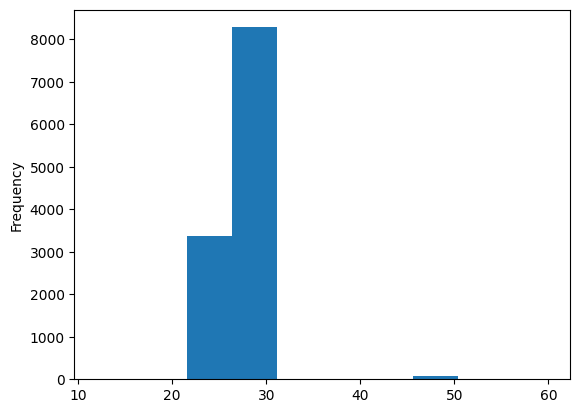

In [8]:
print(metadata.describe())
metadata['framerate'].plot.hist()

<Axes: ylabel='Frequency'>

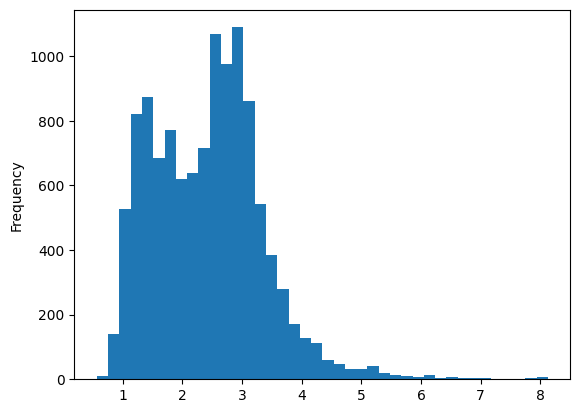

In [9]:
metadata['length_secs'].plot.hist(bins=40)

<Axes: ylabel='Frequency'>

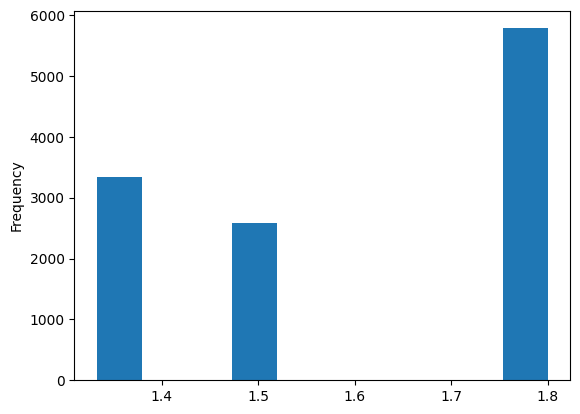

In [10]:
metadata['aspect_ratio'].plot.hist(bins=10)

## Video Ingestion and Transformation

Based on the earlier results, we will normalise the video as such:
- Video aspect ratio stretched to 1.8, i.e. 16:9, as most videos are of that aspect ratio, and if we want to test on real video, most cameras will output 16:9 video. This means that more than half the videos will have to be stretched horizontally. We can also try using the mean of 1.6 instead.
- Video downscaled to 242 x 136 (16:9 ratio).
- RGB channels combined into a Luminosity (grayscale) channel
- Videos will be adjusted to approx 15 fps, by skipping or taking nearest frames.

This should result in a tensor of shape [n, 136, 242, 1], where n/15 is the length of the video. Pooling layers can be used to reduce the resolution further during training.

Once rendered, the video can be re-encoded to reduce the space it takes on the drive even further.

In [51]:
from torchvision import io
from torchvision.transforms import transforms

def calc_skip(framerate):
    if framerate < 15:
        skip = 1 #Take every frame when ~12 fps
    elif framerate < 40:
        skip = 2 #Take every other frame when ~30fps
    else:
        skip = 4 #Take one in 4 frames when ~60fps
    
    return skip

def import_video(id, frame_start, output_size=(242, 136), bbox = None):
    try:
        video, audio, metadata = io.read_video(path + f'/videos/{id}.mp4', pts_unit='sec')
        print(video.shape)
    except:
        print(f'Error parsing video {id}')
        return None
    
    video = video.to('cuda')
    
    if bbox:
        video = video[frame_start-1:, bbox[0]:bbox[2], bbox[1]:bbox[3], :]

    skip = calc_skip(metadata['video_fps'])
    
    trans = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(output_size)
    ])

    scaled_video = trans(video[::skip].permute(0, 3, 2, 1)).permute(0, 3, 2, 1)
    
    return scaled_video

data = import_video(69241, 1)
print(data.shape)

torch.Size([75, 720, 1280, 3])
torch.Size([38, 136, 242, 1])


In [ ]:
import imageio
from tqdm import tqdm

def generate_compressed_dataset(df, output_path):
    writer = imageio.get_writer(output_path, fps=15, codec='h264_nvenc', pixelformat='gray', macro_block_size=1)

    error_videos = []

    for i, (video_id, label, bbox, frame_start) in tqdm(df.iterrows(), total=len(df)):
        vid = import_video(video_id, frame_start)

        if vid is None:
            error_videos.append(video_id)
        else:
            #Ideally, we should directly render the file to the output file without copying back to the cpu... but there doesn't seem to be any good way of doing it at the moment
            for frame in vid.cpu().numpy():
                writer.append_data(frame)
    
    writer.close()

    return error_videos

error_ids = generate_compressed_dataset(df_filtered, 'wlasl_downsampled.mp4')
error_ids = set(error_ids)

with open('errors.txt', 'w') as f:
    f.writelines(id + '\n' for id in error_ids)

 12%|█▏        | 1359/11724 [03:01<21:16,  8.12it/s]Invalid NAL unit size (745 > 472).
Error splitting the input into NAL units.
 12%|█▏        | 1362/11724 [03:01<24:54,  6.93it/s]

Error parsing video 04709


 20%|█▉        | 2329/11724 [05:04<21:00,  7.45it/s]Invalid NAL unit size (71678 > 10776).
missing picture in access unit with size 10780
Invalid NAL unit size (71678 > 10776).
Error splitting the input into NAL units.
 20%|█▉        | 2333/11724 [05:04<19:26,  8.05it/s]

Error parsing video 69211


100%|██████████| 11724/11724 [23:36<00:00,  8.28it/s]


In [79]:
# In case the code is being run from this point
error_ids = set(['04709','69211'])

# Frame length correction
For some reason, the number of frames obtained by pymediadata is slightly off. To correct that, we can use ffprobe to get the actual length of the frames.

Alternatively, we could get them from the dataset directly, but given we didn't store each video individually, this will have to do

In [78]:
import subprocess

def get_vid_frames(path, file):
    cmnd = ['ffprobe', '-v', 'error', '-select_streams', 'v:0', '-count_frames', '-show_entries', 'stream=nb_read_frames', '-of', 'csv=p=0', f'{path}/videos/{file}.mp4']
    p = subprocess.Popen(cmnd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err =  p.communicate()
    return out

actual_frames = df_filtered['video_id'].progress_apply(lambda id: get_vid_frames(path, id))

100%|██████████| 11724/11724 [13:52<00:00, 14.09it/s]


In [116]:
actual_frame_values = pd.to_numeric(actual_frames.apply(lambda b: b.strip().removesuffix(b',')))
actual_frame_values

0        75
1        30
2        68
3        86
4        87
         ..
11719    83
11720    38
11721    58
11722    51
11723    88
Name: video_id, Length: 11724, dtype: int64

# Final output of annotations

In [127]:
import numpy as np

df_noerr_filter = ~df_filtered['video_id'].isin(error_ids)

frames = actual_frame_values / metadata['framerate'].apply(calc_skip)
frames = np.ceil(frames).astype('uint16')
frames = frames[df_noerr_filter]
frames.name = 'length'

offset = frames.cumsum() - frames
offset.name = 'offset'

annotations = pd.concat([df_filtered[df_noerr_filter], offset, frames], axis=1)[['video_id', 'label', 'offset', 'length']]

annotations.to_csv('labels.csv', index=False)
annotations

,video_id,label,offset,length
0,69241,book,0,38
1,07069,book,38,15
2,07068,book,53,34
3,07070,book,87,43
4,07099,book,130,44
...,...,...,...,...
11719,62493,waterfall,403889,42
11720,63044,wheelchair,403931,19
11721,63046,wheelchair,403950,29
11722,63047,wheelchair,403979,26
